In [3]:
%load_ext autoreload
%autoreload 2

from rejax import PPO
from env import NavigationEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
env = NavigationEnv()

config = {
    "env": env,
    "total_timesteps": 1_000_000,
}

ppo = PPO.create(**config)

In [10]:
ppo.config

{'env': <env.NavigationEnv at 0x15721baf0>,
 'env_params': {'max_steps_in_episode': 200,
  'goal_tolerance': 0.1,
  'arena_size': 5.0,
  'dt': 0.1,
  'linear_speed': 1.0,
  'angular_speed': 0.7853981633974483,
  'step_penalty': 0.01,
  'goal_reward': 10.0},
 'eval_callback': <function rejax.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 1000000,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'num_envs': 64,
 'num_steps': 64,
 'num_minibatches': 16,
 'actor': {'action_dim': 3,
  'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'parent': None,
  'name': None},
 'critic': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'parent': None,
  'name': None},
 'num_epochs': 8,
 'gae_lambda': 0.95,
 'clip_eps': 0.2,
 'vf_coef': 0.5,
 'ent_coef': 0.01}

## Training

In [11]:
import jax
import time

# Set the seed for reproducibility
SEED = 13

# Set training seed and jit train function
rng = jax.random.PRNGKey(SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 3.50062 seconds (285664 steps/second).


## Evaluation

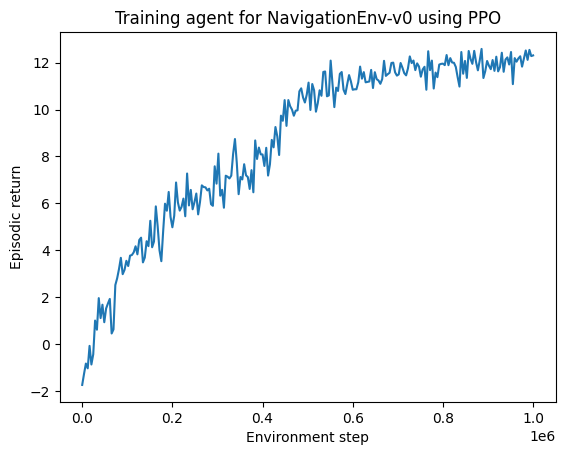

In [12]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, ppo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env.name} using {ppo.__class__.__name__}")
plt.show()


Running 3 episodes and collecting frames...
  Starting Episode 1/3...
  Episode 1 finished after 43 steps.
  Starting Episode 2/3...
  Episode 2 finished after 58 steps.
  Starting Episode 3/3...
  Episode 3 finished after 31 steps.
Finished 3 episodes. Total steps: 132. Total frames: 132.
Saving GIF...
GIF saved to temp/navigation_policy.gif


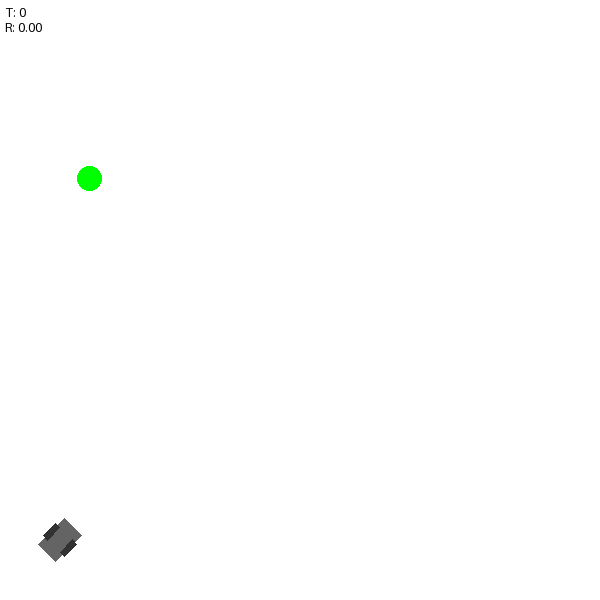

GIF saved as temp/navigation_policy.gif


In [ ]:
import time # Added missing import
from IPython.display import Image as IPImage, display
import env_vis
import os
import jax # Added missing import

# --- Configuration ---
N_EPISODES = 3 # Number of episodes to run
TEST_SEED = 42


# --- 1. Get Agent ---
t0 = time.time()
act = jax.jit(ppo.make_act(train_state))
key = jax.random.PRNGKey(TEST_SEED)

# --- 2. Setup Test Env ---
env = NavigationEnv()
params = env.default_params

# List to store frames for GIF
frames = []
total_steps = 0 # Keep track of total steps across episodes

print(f"Running {N_EPISODES} episodes and collecting frames...")

# --- 3. Run Episodes & Collect Frames ---
for i_episode in range(N_EPISODES):
    key, reset_key = jax.random.split(key)
    obs, state = env.reset(reset_key, params)
    done = False
    episode_steps = 0

    while not done:
        # Render current state to a NumPy frame BEFORE stepping
        # This now uses the Pillow-based render_frame method
        frame = env_vis.render_frame(state, params)
        frames.append(frame)

        # Choose action and step environment
        key, act_key, step_key = jax.random.split(key, 3)
        action = act(obs, act_key)
        obs, state, _, done, _ = env.step(step_key, state, action, params)
        episode_steps += 1

    print(f"  Episode {i_episode + 1} finished after {episode_steps} steps.")
    total_steps += episode_steps

print(f"Finished {N_EPISODES} episodes. Total steps: {total_steps}. Total frames: {len(frames)}.")

# --- 4. Save and Display GIF ---
print("Saving GIF...")
os.makedirs("temp", exist_ok=True)
gif_filename = "temp/navigation_policy.gif"
env_vis.save_gif(frames, gif_filename, duration_per_frame=100)

# Display the GIF in the notebook
display(IPImage(filename=gif_filename))
print(f"GIF saved as {gif_filename}")